<a href="https://colab.research.google.com/github/manjus3/gemini-ai-experiments/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [5]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Model tuning with Python

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs/model-tuning/python"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this notebook, you'll learn how to get started with the tuning service using the Python client library for the Gemini API. Here, you'll learn how to tune the text model behind the Gemini API's text generation service.

**Note**: At this time, tuning is only available for the `gemini-1.0-pro-001` model.

## Setup

### Authenticate

The Gemini API lets you tune models on your own data. Since it's your data and
your tuned models this needs stricter access controls than API-Keys can provide.

Before you can run this tutorial, you'll need to
[setup OAuth for your project](https://ai.google.dev/gemini-api/docs/oauth).


In Colab the easiest wat to get setup is to copy the contents of your `client_secret.json` file into Colab's "Secrets manager" (under the key icon in the left panel) with the secret name `CLIENT_SECRET`.

This gcloud command turns the `client_secret.json` file into credentials that can be used to authenticate with the service.

> Important: If you're running this in Colab, **don't just click the link it prints**. That will fail. Follow the instructions and copy the `gcloud` command it prints to your local machine and run it there, then paste the output from your local machine back here.


In [6]:
import os
if 'COLAB_RELEASE_TAG' in os.environ:
  from google.colab import userdata
  import pathlib
  pathlib.Path('client_secret.json').write_text(userdata.get('CLIENT_SECRET'))

  # Use `--no-browser` in colab
  !gcloud auth application-default login --no-browser --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'
else:
  !gcloud auth application-default login --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'


You are running on a Google Compute Engine virtual machine.
The service credentials associated with this virtual machine
will automatically be used by Application Default
Credentials, so it is not necessary to use this command.

If you decide to proceed anyway, your user credentials may be visible
to others with access to this virtual machine. Are you sure you want
to authenticate with your personal account?

Do you want to continue (Y/n)?  y

You are authorizing client libraries without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.

gcloud auth application-default login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=492314808448-516estpmfot81a703b8hcis7v3i2p2lq.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-langua

### Install the client library

In [7]:
!pip install -q google-generativeai

### Import libraries

In [8]:
import google.generativeai as genai

You can check you existing tuned models with the `genai.list_tuned_model` method.

In [10]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [11]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
base_model

Model(name='models/gemini-1.0-pro-001',
      base_model_id='',
      version='001',
      display_name='Gemini 1.0 Pro 001 (Tuning)',
      description=('The best model for scaling across a wide range of tasks. This is a stable '
                   'model that supports tuning.'),
      input_token_limit=30720,
      output_token_limit=2048,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=0.9,
      top_p=1.0,
      top_k=None)

In [12]:
import random

name = f'generate-num-{random.randint(0,10000)}'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    training_data=[
        {
             'text_input': '1',
             'output': '2',
        },{
             'text_input': '3',
             'output': '4',
        },{
             'text_input': '-3',
             'output': '-2',
        },{
             'text_input': 'twenty two',
             'output': 'twenty three',
        },{
             'text_input': 'two hundred',
             'output': 'two hundred one',
        },{
             'text_input': 'ninety nine',
             'output': 'one hundred',
        },{
             'text_input': '8',
             'output': '9',
        },{
             'text_input': '-98',
             'output': '-97',
        },{
             'text_input': '1,000',
             'output': '1,001',
        },{
             'text_input': '10,100,000',
             'output': '10,100,001',
        },{
             'text_input': 'thirteen',
             'output': 'fourteen',
        },{
             'text_input': 'eighty',
             'output': 'eighty one',
        },{
             'text_input': 'one',
             'output': 'two',
        },{
             'text_input': 'three',
             'output': 'four',
        },{
             'text_input': 'seven',
             'output': 'eight',
        }
    ],
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [13]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/generate-num-7862',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='',
           description='',
           temperature=0.9,
           top_p=1.0,
           top_k=0,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 6, 4, 21, 45, 25, 59350, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 6, 4, 21, 45, 25, 59350, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2024, 6, 4, 21, 45, 25, 561324, tzinfo=datetime.timezone.utc),
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=4,
                                                                  learning_rate=0.001))

In [14]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [15]:
operation.metadata

total_steps: 375
tuned_model: "tunedModels/generate-num-7862"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [16]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/375 [00:00<?, ?it/s]

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

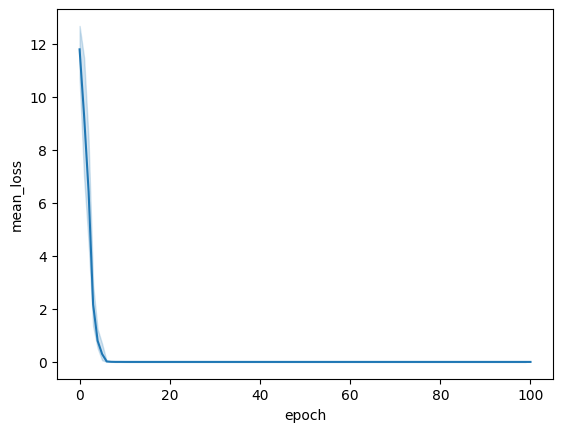

In [17]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [18]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [19]:
result = model.generate_content('55')
result.text

'56'

In [20]:
result = model.generate_content('123455')
result.text

'123456'

In [21]:
result = model.generate_content('four')
result.text

'five'

In [22]:
result = model.generate_content('quatre') # French 4
result.text                               # French 5 is "cinq"

'cinq'

In [23]:
result = model.generate_content('III')    # Roman numeral 3
result.text                               # Roman numeral 4 is IV

'IV'

In [24]:
result = model.generate_content('七')  # Japanese 7
result.text                            # Japanese 8 is 八!

'八'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/gemini-api/docs/model-tuning) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [25]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [26]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [ ]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [ ]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 Tuned model tunedModels/generate-num-2946 does not exist.
